In [1]:
import sys
import os
import glob

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

from mpl_toolkits import mplot3d
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean

from scipy import interpolate
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy import stats # Import the scipy.stats module
from scipy.optimize import curve_fit # Import the curve fitting module


import Functions_dataprep as fdp

import sklearn
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

import dask.config as dc
dc.set(**{'array.slicing.split_large_chunks': True});

import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm # to build a LOWESS model
from scipy.interpolate import interp1d # for interpolation of new data points
lowess = sm.nonparametric.lowess

In [2]:
data_dir = '/Volumes/T7/DATA_knmi/'

In [3]:
'''
In this cell, you can specify the dynamic sea-level region of interest - so the region 
we take the spatial average over.
In my thesis, I mostly focus on the KNMI14 region / North Sea. 
The latitudes and longitudes can be found below, you can adjust them yourself.  
We take the slice of the data, so that's including the coordinates below.
'''

# KNMI14 / North Sea
lat_min, lat_max = 51.5, 59.5     
lon_min, lon_max = -3.5, 7.5

# Bay of Biscay 45° 13' 27.9" N (45.2244286°), 3° 56' 6.5" W (-3.93513546°)
#lat_min, lat_max = 43.5, 48.5     
#lon_min, lon_max = -9.5, -0.5
# New York
#lat_min, lat_max = 38.5, 42.5     
#lon_min, lon_max = -73.5, -68.5

# Florida 27.994402, and the longitude is -81.760254
#lat_min, lat_max = 24.5, 32.5     
#lon_min, lon_max = -80.5, -73.5

# Phillipines, 11°48′10.80″ North, longitude 122°33′46.80″
#lat_min, lat_max = 9.5, 13.5     
#lon_min, lon_max = 119.5, 125.5

# Smaller North Sea region
#lat_min, lat_max = 51, 54     
#lon_min, lon_max = -1.5, 7.5

In [4]:
'''
In this cell, we define the reference period. 
We calculate the mean of this period for each variable and subtract this from the data.
We do this for:
- CMIP5 and CMIP6 data 
- assessed ranges AR6, GSAT and zostoga
- observations GSAT and zostoga
- reanalysis and budgets of DSL
'''

ref_start, ref_end = 1990, 2005

## CMIP data

In [5]:
def read_amoc_ds(data_dir, mip, sce):
    '''
    Read both historical and scenario datasets, select the intersecting 
    models and concatenate the two datasets. 
    '''
    
    tot_ds = []
    
    varsname5 = ['msftmyz']
    varsname6 = ['msftmz','msftyz']
    
    # From mstmz to sverdrup 
    DF = 1026*10**6 
    
    if mip == 'cmip5':
        varss = varsname5
    elif mip == 'cmip6':
        varss = varsname6
    else:
        print('mip is not recognized')
        
    for var in varss:
        for reg in ['26N', '35N']:
            hist_ds = xr.open_mfdataset(
                f'{data_dir}/{mip}_amoc/{mip}_{var}_{reg}_historical_*.nc')
            sce_ds = xr.open_mfdataset(
                f'{data_dir}/{mip}_amoc/{mip}_{var}_{reg}_{sce}_*.nc')
            
            if sce == 'rcp45':
                sce_ds = sce_ds.isel(model=[0,1,2,3,4,5,7,8,9,10,11])
            
            model_intersection = list(set(hist_ds.model.values) & set(sce_ds.model.values))
            model_intersection.sort()
            
            if sce == 'rcp45':
                model_intersection.remove('CNRM-CM5')
                CNRM5 = xr.concat([hist_ds,sce_ds],'time').sel(model='CNRM-CM5')*10**6
                Mods_no = xr.concat([hist_ds,sce_ds],'time').sel(model=model_intersection)
                tot_ds.append(xr.concat([Mods_no,CNRM5],'model')) #.sel(model=model_intersection))
            
            else:
                tot_ds.append(xr.concat([hist_ds,sce_ds],'time').sel(model=model_intersection))
            
            

    if mip == 'cmip5':
        my26N, my35N = tot_ds
        
        
        xr_my = xr.Dataset(
            data_vars=dict(
                AMOC26 = (["model", "time"], my26N.msftmyz.values/DF),
                AMOC35 = (["model", "time"], my35N.msftmyz.values/DF),
            ),
            coords=dict(
                model= my26N.model.values,
                time = my26N.time.values,
            ),
            attrs=dict(description="Dataset with AMOC, zos data."),
        )
        AMOC = xr_my
        
    elif mip == 'cmip6':
        m26N, m35N, y26N, y35N = tot_ds
    
        modsm = m26N.model.values
        modsy = y26N.model.values
    
        overlap = np.sort(list(set(modsm)&set(modsy)))
    
        new_modsy = np.array([ele for ele in modsy if ele not in overlap])
    
        y26N = y26N.sel(model=new_modsy)
        y35N = y35N.sel(model=new_modsy)
    
    
    
        xr_m = xr.Dataset(
            data_vars=dict(
                AMOC26 = (["model", "time"], m26N.msftmz.values/DF),
                AMOC35 = (["model", "time"], m35N.msftmz.values/DF),
            ),
            coords=dict(
                model= modsm,
                time = m26N.time.values,
            ),
            attrs=dict(description="Dataset with AMOC, zos data."),
        )
    
        xr_y = xr.Dataset(
            data_vars=dict(
                AMOC26 = (["model", "time"], y26N.msftyz.values/DF),
                AMOC35 = (["model", "time"], y35N.msftyz.values/DF),
            ),
            coords=dict(
                model= new_modsy,
                time = y26N.time.values,
            ),
            attrs=dict(description="Dataset with AMOC, zos data."),
        )
    
        AMOC = xr.concat([xr_m, xr_y],'model')
    
    return AMOC

In [9]:
# GSAT
GSAT_list, zostoga_list, zos_list, AMOC_list = [],[],[],[]
for sce in ['rcp26', 'rcp45', 'rcp85']:
    GSAT_r = fdp.tglob_cmip(data_dir, 'CMIP5', sce, 1860.5, 2100.5, LowPass=False)
    GSAT = GSAT_r.assign_coords(time = np.arange(1861.5,2101.5))
    GSAT_list.append(GSAT)

    zostoga = fdp.read_zostoga_ds(data_dir, 'cmip5', sce)
    zostoga_list.append(zostoga)

    zos = fdp.read_zos_ds(data_dir, 'cmip5', sce)
    zos_data = zos.sel(lat=slice(lat_min,lat_max), lon=slice(lon_min,lon_max)).mean(dim=['lon','lat'])
    zos_data = zos_data.rename({'CorrectedReggrided_zos':'zos'})
    zos_list.append(zos_data)
    
    amoc = read_amoc_ds(data_dir, 'cmip5', sce)
    AMOC_list.append(amoc)

    # Combine the three variables into one dataset per scenario:
datasets = []
for i in range(3):
    dataset = xr.merge([zos_list[i], zostoga_list[i], \
                               GSAT_list[i], AMOC_list[i]], compat="no_conflicts")
    dataset = dataset.rename({'zostoga_corrected':'zostoga'})
    datasets.append(dataset)

dataset_rcp26, dataset_rcp45, dataset_rcp85 = datasets

datasets_def = []
scenarios = ['l', 'm', 'h']

for i, dss in enumerate([dataset_rcp26, dataset_rcp45, dataset_rcp85]):
    
    dss = dss.rename({'zos':f'zos_{scenarios[i]}'})
    dss = dss.rename({'zostoga':f'zostoga_{scenarios[i]}'})
    dss = dss.rename({'GSAT':f'GSAT_{scenarios[i]}'})
    dss = dss.rename({'AMOC26':f'AMOC26_{scenarios[i]}'})
    dss = dss.rename({'AMOC35':f'AMOC35_{scenarios[i]}'})
    dss = dss.rename({'trend_picontrol':f'trend_picontrol_{scenarios[i]}'})
    
    datasets_def.append(dss)
    
# Combine all values in one dataset
ds_comb = xr.merge([datasets_def[0],datasets_def[1],datasets_def[2]], compat="no_conflicts")

# Separate values for zos, zostoga, GSAT 
zosses = np.array([ds_comb.zos_l.values, ds_comb.zos_m.values, ds_comb.zos_h.values])
zostogas = np.array([ds_comb.zostoga_l.values, ds_comb.zostoga_m.values, ds_comb.zostoga_h.values])
GSATs = np.array([ds_comb.GSAT_l.values, ds_comb.GSAT_m.values, ds_comb.GSAT_h.values])
AMOC26s = np.array([ds_comb.AMOC26_l.values, ds_comb.AMOC26_m.values, ds_comb.AMOC26_h.values])
AMOC35s = np.array([ds_comb.AMOC35_l.values, ds_comb.AMOC35_m.values, ds_comb.AMOC35_h.values])

# Rearrange dataset for CMIP5 so that we have dimensions: 'scenario', 'model', 'time' 
data_zos = zosses
data_zostoga = zostogas
data_GSAT = GSATs
data_AMOC26 = AMOC26s
data_AMOC35 = AMOC35s

# create coords
mods = ds_comb.model.values
sces = ['ssp126', 'ssp245', 'ssp585']
times = ds_comb.time.values

# put data into a dataset
CMIP5_ds = xr.Dataset(
    data_vars=dict(
        zos=(["scenario","model" , "time"], data_zos),
        zostoga=(["scenario","model" , "time"], data_zostoga),
        GSAT=(["scenario","model" , "time"], data_GSAT),
        AMOC26=(["scenario","model" , "time"], data_AMOC26),
        AMOC35=(["scenario","model" , "time"], data_AMOC35)
    ),
    coords=dict(
        model=(["model"], mods),
        scenario=(["scenario"], sces),
        time =(["time"],times)
    ),
    attrs=dict(description="CMIP5 dataset with variables dynamic sea-level (zos), global mean steric sea-level (zostoga), and global surface air temperature (GSAT)"),
)

CMIP5_ds = CMIP5_ds - CMIP5_ds.sel(time=slice(ref_start, ref_end)).mean(dim='time')

In [8]:
# GSAT
GSAT_list = []
zostoga_list = []
zos_list = []
AMOC_list = []
    
for sce in ['ssp126', 'ssp245', 'ssp585']:
    GSAT = fdp.tglob_cmip(data_dir, 'CMIP6', sce, 1850, 2100.5, LowPass=False)
    GSAT = GSAT.assign_coords(time = np.arange(1850,2101)+.5)
    GSAT_list.append(GSAT)
    
    zostoga = fdp.read_zostoga_ds(data_dir, 'cmip6', sce)
    zostoga_list.append(zostoga)
    
    zos = fdp.read_zos_ds(data_dir, 'cmip6', sce)
    zos_data = zos.sel(lat=slice(lat_min,lat_max), lon=slice(lon_min,lon_max)).mean(dim=['lon','lat'])
    zos_data = zos_data.rename({'CorrectedReggrided_zos':'zos'})
    zos_list.append(zos_data)
    
    amoc = read_amoc_ds(data_dir, 'cmip6', sce)
    AMOC_list.append(amoc)
    
# Combine the three variables into one dataset per scenario:
datasets = []
for i in range(3):
    dataset = xr.merge([zos_list[i], zostoga_list[i], GSAT_list[i], AMOC_list[i]], compat="no_conflicts")
    dataset = dataset.rename({'zostoga_corrected':'zostoga'})
    datasets.append(dataset)

dataset_rcp26, dataset_rcp45, dataset_rcp85 = datasets

datasets_def = []
scenarios = ['l', 'm', 'h']

for i, dss in enumerate([dataset_rcp26, dataset_rcp45, dataset_rcp85]):
    
    dss = dss.rename({'zos':f'zos_{scenarios[i]}'})
    dss = dss.rename({'zostoga':f'zostoga_{scenarios[i]}'})
    dss = dss.rename({'GSAT':f'GSAT_{scenarios[i]}'})
    dss = dss.rename({'AMOC26':f'AMOC26_{scenarios[i]}'})
    dss = dss.rename({'AMOC35':f'AMOC35_{scenarios[i]}'})
    dss = dss.rename({'trend_picontrol':f'trend_picontrol_{scenarios[i]}'})
    
    datasets_def.append(dss)
    
# Combine all values in one dataset
ds_comb = xr.merge([datasets_def[0],datasets_def[1],datasets_def[2]], compat="no_conflicts")

# Separate values for zos, zostoga, GSAT 
zosses = np.array([ds_comb.zos_l.values, ds_comb.zos_m.values, ds_comb.zos_h.values])
zostogas = np.array([ds_comb.zostoga_l.values, ds_comb.zostoga_m.values, ds_comb.zostoga_h.values])
GSATs = np.array([ds_comb.GSAT_l.values, ds_comb.GSAT_m.values, ds_comb.GSAT_h.values])
AMOC26s = np.array([ds_comb.AMOC26_l.values, ds_comb.AMOC26_m.values, ds_comb.AMOC26_h.values])
AMOC35s = np.array([ds_comb.AMOC35_l.values, ds_comb.AMOC35_m.values, ds_comb.AMOC35_h.values])

# Rearrange dataset for CMIP5 so that we have dimensions: 'scenario', 'model', 'time' 
data_zos = zosses
data_zostoga = zostogas
data_GSAT = GSATs
data_AMOC26 = AMOC26s
data_AMOC35 = AMOC35s

# create coords
mods = ds_comb.model.values
sces = ['ssp126', 'ssp245', 'ssp585']
times = ds_comb.time.values

# put data into a dataset
CMIP6_ds = xr.Dataset(
    data_vars=dict(
        zos=(["scenario","model" , "time"], data_zos),
        zostoga=(["scenario","model" , "time"], data_zostoga),
        GSAT=(["scenario","model" , "time"], data_GSAT),
        AMOC26=(["scenario","model" , "time"], data_AMOC26),
        AMOC35=(["scenario","model" , "time"], data_AMOC35)
    ),
    coords=dict(
        model=(["model"], mods),
        scenario=(["scenario"], sces),
        time =(["time"],times)
    ),
    attrs=dict(description="CMIP6 dataset with variables dynamic sea-level (zos), global mean steric sea-level (zostoga), and global surface air temperature (GSAT)"),
)

CMIP6_ds = CMIP6_ds - CMIP6_ds.sel(time=slice(ref_start, ref_end)).mean(dim='time')


In [103]:
CMIP5_ds.to_netcdf(path='data_processed/ds_CMIP5.nc')
CMIP6_ds.to_netcdf(path='data_processed/ds_CMIP6.nc')


In [10]:
def CMIP_LOWESS(ds, window, mip):
    frac = window/ds.time.values.shape[0]


    mods = ds.model.values
    sces = ['ssp126', 'ssp245', 'ssp585']

    LF_data_zos = [[],[],[]]
    LF_data_zostoga = [[],[],[]]
    LF_data_GSAT = [[],[],[]]
    LF_data_AMOC26 = [[],[],[]]
    LF_data_AMOC35 = [[],[],[]]
    # Loop over scenario, model, variable:
    for i, scen in enumerate(['ssp126','ssp245','ssp585']):
        
        #for variab in enumerate['zos','zostoga','GSAT','AMOC26']:
            
        for mod in mods:

            LF_data_zos[i].append(lowess(ds.sel(scenario=scen, model=mod)['zos'].values, 
                                         ds['time'].values, frac, return_sorted=False))
            LF_data_GSAT[i].append(lowess(ds.sel(scenario=scen, model=mod)['GSAT'].values, 
                           ds['time'].values, frac, return_sorted=False))
            LF_data_zostoga[i].append(lowess(ds.sel(scenario=scen, model=mod)['zostoga'].values, 
                           ds['time'].values, frac, return_sorted=False))

            LF_data_AMOC26[i].append(lowess(ds.sel(scenario=scen, model=mod)['AMOC26'].values, 
                           ds['time'].values, frac, return_sorted=False))
            LF_data_AMOC35[i].append(lowess(ds.sel(scenario=scen, model=mod)['AMOC35'].values, 
                           ds['time'].values, frac, return_sorted=False))
    
    
    # Store arrays in ds

    if mip == 'cmip5':
        ds_LOWESS = xr.Dataset(
            data_vars=dict(
                zos=(["scenario", "model" , "time"], LF_data_zos),
                zostoga=(["scenario","model" , "time"], LF_data_zostoga),
                GSAT=(["scenario","model" , "time"], LF_data_GSAT),
                AMOC26=(["scenario","model" , "time"], LF_data_AMOC26),
                AMOC35=(["scenario","model" , "time"], LF_data_AMOC35)
            ),
            coords=dict(
                model=(["model"], mods),
                scenario=(["scenario"], sces),
                time =(["time"],ds['time'].values)
            ),
                attrs=dict(description="CMIP5 dataset - LOWESS FILTER - with variables dynamic sea-level (zos), \
                global mean steric sea-level (zostoga), and global surface air temperature (GSAT), \
                AMOC strength at 26 degrees (AMOC26) and at 35 degrees (AMOC35)"),
            )
        
    elif mip =='cmip6':
        ds_LOWESS = xr.Dataset(
            data_vars=dict(
                zos=(["scenario", "model" , "time"], LF_data_zos),
                zostoga=(["scenario","model" , "time"], LF_data_zostoga),
                GSAT=(["scenario","model" , "time"], LF_data_GSAT),
                AMOC26=(["scenario","model" , "time"], LF_data_AMOC26),
                AMOC35=(["scenario","model" , "time"], LF_data_AMOC35)
            ),
            coords=dict(
                model=(["model"], mods),
                scenario=(["scenario"], sces),
                time =(["time"],ds['time'].values)
            ),
                attrs=dict(description="CMIP6 dataset - LOWESS FILTER - with variables dynamic sea-level (zos), \
                global mean steric sea-level (zostoga), and global surface air temperature (GSAT), \
                AMOC strength at 26 degrees (AMOC26) and at 35 degrees (AMOC35)"),
            )
        
    return ds_LOWESS

## LOWESS filtered CMIP files

In [11]:
CMIP5ds_new = CMIP5_ds.sel(time=slice(1900,2101))
LF_5 = CMIP_LOWESS(CMIP5ds_new, 10, 'cmip5')

CMIP6ds_new = CMIP6_ds.sel(time=slice(1900,2101))
LF_6 = CMIP_LOWESS(CMIP6ds_new, 10, 'cmip6')

LF_5 = LF_5 - LF_5.sel(time=slice(ref_start,ref_end)).mean(dim='time')
LF_6 = LF_6 - LF_6.sel(time=slice(ref_start,ref_end)).mean(dim='time')

In [12]:
LF_5.to_netcdf(path='data_processed/ds_CMIP5_LF_10.nc')
LF_6.to_netcdf(path='data_processed/ds_CMIP6_LF_10.nc')

## GSAT, zostoga: observations and assessed AR6 ranges

#### Observations

In [11]:
# GSAT - HadCRUT5
ds = xr.open_dataset(data_dir+'/GSAT_obs2.nc', decode_times=False)
time_array_gsat = np.arange(1850, 2022)
mean = ds.tas_mean
upps = ds.tas_upper
lows = ds.tas_lower

d = {'Date': time_array_gsat, 'G_5th': lows, 'G_50th': mean, 'G_95th': upps} # Note that it's actually 2.5% - 97.5%
df_gs = pd.DataFrame(data=d)
df_gs['G_5th'] = df_gs['G_5th'].rolling(window=10,center=True).mean()
df_gs['G_50th'] = df_gs['G_50th'].rolling(window=10,center=True).mean()
df_gs['G_95th'] = df_gs['G_95th'].rolling(window=10,center=True).mean()
df_gs = df_gs.set_index('Date');

gs_ref = df_gs.loc[ref_start:ref_end-1]

# Zostoga - ADD SOURCE
ds_zt = xr.open_dataset(data_dir+'/Zost_obs_thermosteric.nc4', decode_times=False)
mean = ds_zt.global_average_thermosteric_sea_level_change/10
upps = ds_zt.global_average_thermosteric_sea_level_change_upper/10
lows = ds_zt.global_average_thermosteric_sea_level_change_lower/10
time_array_zt = np.arange(1900,2019)

d = {'Date': time_array_zt, 'z_5th': lows,'z_50th': mean, 'z_95th': upps}
df_zt = pd.DataFrame(data=d)
df_zt = df_zt.set_index('Date')

zt_ref = df_zt.loc[ref_start:ref_end-1]

df_obs = pd.concat([df_gs, df_zt], axis=1)


#### AR6 ranges

In [12]:
# GSAT - very likely ranges (5th to 95th percentile)
GSAT_AR6_m     = np.array([[0.85, 1.5, 1.7, 1.8], [0.85, 1.5, 2.0, 2.7], [0.85, 1.6, 2.4, 4.4]]) - 0.85 +0.26
GSAT_AR6_5ths  = np.array([[0.85, 1.2, 1.3, 1.3], [0.85, 1.2, 1.6, 2.1], [0.85, 1.3, 1.9, 3.3]]) - 0.85 +0.26
GSAT_AR6_95ths = np.array([[0.85, 1.8, 2.2, 2.4], [0.85, 1.8, 2.5, 3.5], [0.85, 1.9, 3.0, 5.7]]) - 0.85 +0.26

AR6_GSAT = np.concatenate([[GSAT_AR6_m], [GSAT_AR6_5ths], [GSAT_AR6_95ths]])

# Create arrays for new data
GSAT_new = np.zeros([3,3,96])

# Arrays for old and new time series
x_old = np.array([2005, 2031, 2051, 2091])
x_new = np.linspace(2005, 2100, 96)

order = 3
# Loop over all scenarios and means, upper and lower bound
for i in range(3): #mean, lower, upper
    for j in range(3): #scenario
        y_old = AR6_GSAT[i,j]        
        s = InterpolatedUnivariateSpline(x_old, y_old, k=order)
        y_new = s(x_new)
        GSAT_new[i,j] = y_new

In [13]:
# ZOSTOGA - percentiles from NASA per 10 year
zost126 = xr.open_dataset(data_dir+'AR6_Projections_NASA/Global/medium_confidence/ssp126/\
oceandynamics_ssp126_medium_confidence_values.nc')
zost245 = xr.open_dataset(data_dir+'AR6_Projections_NASA/Global/medium_confidence/ssp245/\
oceandynamics_ssp245_medium_confidence_values.nc')
zost585 = xr.open_dataset(data_dir+'AR6_Projections_NASA/Global/medium_confidence/ssp585/\
oceandynamics_ssp585_medium_confidence_values.nc')

# Select percentiles
AR6_zt_126 = fdp.zostoga_ranges(zost126, [0.05,0.5,0.95], 2020, 2100)
AR6_zt_245 = fdp.zostoga_ranges(zost245, [0.05,0.5,0.95], 2020, 2100)
AR6_zt_585 = fdp.zostoga_ranges(zost585, [0.05,0.5,0.95], 2020, 2100)

zt_AR6_m = np.concatenate([[AR6_zt_126[1]], [AR6_zt_245[1]], [AR6_zt_585[1]]])
zt_AR6_5ths = np.concatenate([[AR6_zt_126[0]], [AR6_zt_245[0]], [AR6_zt_585[0]]])
zt_AR6_95ths = np.concatenate([[AR6_zt_126[2]], [AR6_zt_245[2]], [AR6_zt_585[2]]])

AR6_zt = np.concatenate([[zt_AR6_m], [zt_AR6_5ths], [zt_AR6_95ths]])

AR6_zt_new = np.zeros([3,3,10,1])
AR6_zt_new[:,:,1:] = AR6_zt
zt_new = np.zeros([3,3,96])

x_old_z = np.array([2005,2020, 2030, 2040,2050,2060,2070,2080,2090,2100])
x_new_z = np.linspace(2005, 2100, 96)

for i in range(3): #mean, lower, upper
    for j in range(3): #scenario
        y_old = AR6_zt_new[i,j]        
        s = InterpolatedUnivariateSpline(x_old_z, y_old, k=order)
        y_new = s(x_new_z)
        zt_new[i,j] = y_new

In [14]:
# Create pd dataframe for each scenario with ranges GSAT and ranges zostoga
time = np.arange(2005,2101,1)

# low emission scenario
d = {'Date': time, 
     'G_5th': np.round(GSAT_new[1][0],3), 'G_50th': np.round(GSAT_new[0][0],3), 'G_95th': np.round(GSAT_new[2][0],3),
     'z_5th': np.round(zt_new[1][0],3), 'z_50th': np.round(zt_new[0][0],3), 'z_95th': np.round(zt_new[2][0],3),
    }
df_low = pd.DataFrame(data=d)
df_low = df_low.set_index('Date')

# mid emission scenario
d = {'Date': time, 
     'G_5th': np.round(GSAT_new[1][1],3), 'G_50th': np.round(GSAT_new[0][1],3), 'G_95th': np.round(GSAT_new[2][1],3),
     'z_5th': np.round(zt_new[1][1],3), 'z_50th': np.round(zt_new[0][1],3), 'z_95th': np.round(zt_new[2][1],3),
    }
df_mid = pd.DataFrame(data=d)
df_mid = df_mid.set_index('Date')

# high emission scenario
d = {'Date': time, 
     'G_5th': np.round(GSAT_new[1][2],3), 'G_50th': np.round(GSAT_new[0][2],3), 'G_95th': np.round(GSAT_new[2][2],3),
     'z_5th': np.round(zt_new[1][2],3), 'z_50th': np.round(zt_new[0][2],3), 'z_95th': np.round(zt_new[2][2],3),
    }
df_high = pd.DataFrame(data=d)
df_high = df_high.set_index('Date')

In [15]:
# make sure that time series of observations connect to AR6 ranges by setting 2017 as merge year
yr_merge = 2005

for dfs in [df_low, df_mid, df_high, df_obs]:
    dfs.iloc[:,0:3] = dfs.iloc[:,0:3] - dfs.loc[yr_merge:yr_merge].mean()[1]
    dfs.iloc[:,3:6] = dfs.iloc[:,3:6] - dfs.loc[yr_merge:yr_merge].mean()[4]

In [16]:
df_lows = pd.concat([df_obs.loc[1900:2005], df_low.loc[2006:2100]])
df_mids = pd.concat([df_obs.loc[1900:2005], df_mid.loc[2006:2100]])
df_higs = pd.concat([df_obs.loc[1900:2005], df_high.loc[2006:2100]])

df_lows = df_lows - df_lows.loc[ref_start:ref_end-1].mean()
df_mids = df_mids - df_mids.loc[ref_start:ref_end-1].mean()
df_higs = df_higs - df_higs.loc[ref_start:ref_end-1].mean()

df_lows.to_csv(os.getcwd() + '/data_processed/AR6_obs17_low_perc.csv')
df_mids.to_csv(os.getcwd() + '/data_processed/AR6_obs17_mid_perc.csv')
df_higs.to_csv(os.getcwd() + '/data_processed/AR6_obs17_hig_perc.csv')

Text(0, 0.5, 'GSAT anomaly (K)')

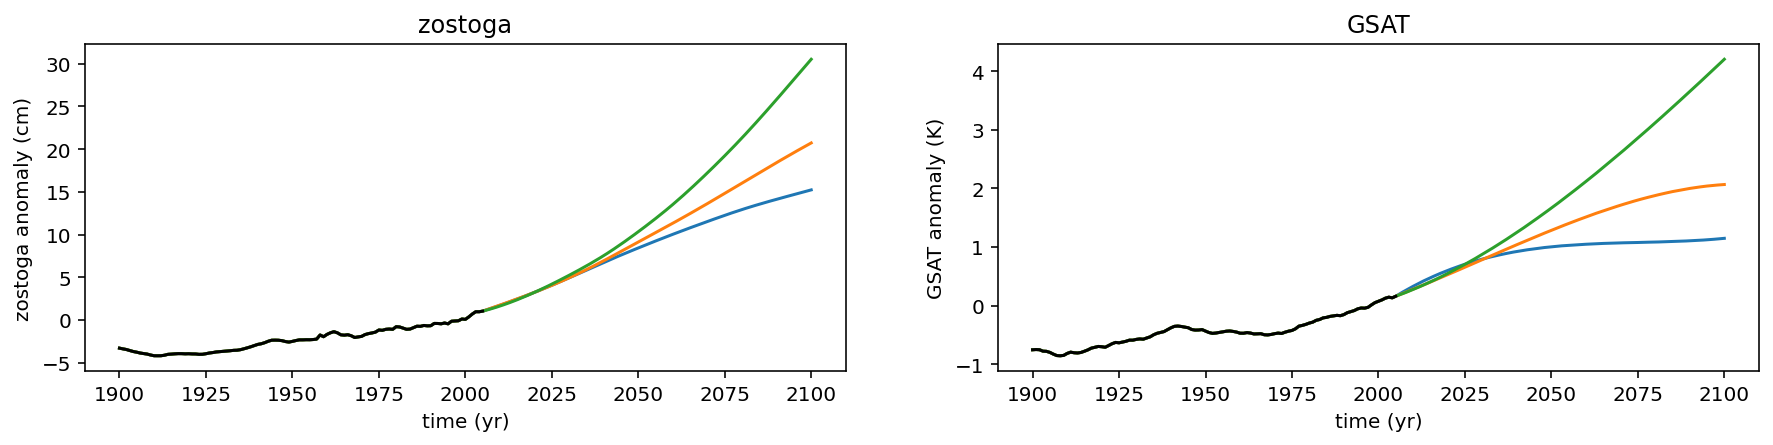

In [17]:
fig, ax = plt.subplots(1,2,figsize=(15,3))

ax[0].plot(df_lows['z_50th'].loc[1900:2100])
ax[0].plot(df_mids['z_50th'].loc[1900:2100])
ax[0].plot(df_higs['z_50th'].loc[1900:2100])
ax[0].plot(df_higs['z_50th'].loc[1900:2005], c='k')

ax[0].set_title('zostoga')
ax[0].set_xlabel('time (yr)')
ax[0].set_ylabel('zostoga anomaly (cm)')

ax[1].plot(df_lows['G_50th'].loc[1900:2100])
ax[1].plot(df_mids['G_50th'].loc[1900:2100])
ax[1].plot(df_higs['G_50th'].loc[1900:2100])
ax[1].plot(df_higs['G_50th'].loc[1900:2005], c='k')

ax[1].set_title('GSAT')
ax[1].set_xlabel('time (yr)')
ax[1].set_ylabel('GSAT anomaly (K)')

## DSL reanalysis and budgets

In [5]:
# Sea-level budget +
df_slbudget1 = pd.read_csv(f'/Volumes/T7/DATA_knmi/slbudget_2020_12_03_ZSM_1979_2018_ERA5StericEN4_4000m.csv').set_index('time')
df_slbudget2 = pd.read_csv(f'/Volumes/T7/DATA_knmi/slbudget_2021_12_13_NS_Fred16_1950_2020_ERA5_StericIAP_1100m.csv').set_index('time')

df_slbudget1 = df_slbudget1 - df_slbudget1.loc[ref_start:ref_end-1].mean()
df_slbudget2 = df_slbudget2 - df_slbudget2.loc[ref_start:ref_end-1].mean()

df_slbudget1 = df_slbudget1['LocSteric']
df_slbudget2 = df_slbudget2['LocSteric']

df_slbudget1.to_csv(os.getcwd() + f'/data_processed/DSL_b1.csv')
df_slbudget2.to_csv(os.getcwd() + f'/data_processed/DSL_b2.csv')


In [11]:
# ora20C reanalysis
ds_ora20c = xr.open_mfdataset(f'/Volumes/T7/DATA_knmi/Observations_zos_ora20c.nc')
ds_ora20c = ds_ora20c - ds_ora20c.sel(year=slice(ref_start,ref_end)).mean(dim=['year','member'])

frac = 25/ds_ora20c.year.values.shape[0]

LF_ora20c = []

for memb in ds_ora20c.member.values:
    LF_zos = lowess(ds_ora20c.sel(member=memb)['zos'].values, 
                            ds_ora20c['year'].values, frac, return_sorted=False)
    LF_ora20c.append(LF_zos)
    
ds_ora20c_new = xr.Dataset(
    data_vars=dict(
        zos=(["member","year"], ds_ora20c.zos.values),
        LF_zos=(["member","year"], LF_ora20c)
    ),
    coords=dict(
        model=(["member"], ds_ora20c.member.values),
        year =(["year"],ds_ora20c.year.values)
    ),
    attrs=dict(description="ORA20C dataset with zos, and LOWESS filtered zos (window = 25 yr)"),
)

ds_ora20c_new.to_netcdf(os.getcwd() + f'/data_processed/DSL_ora20c.nc')
